<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fake-News-Corpus" data-toc-modified-id="Fake-News-Corpus-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fake News Corpus</a></span></li><li><span><a href="#Libraries" data-toc-modified-id="Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#dask.dataframe" data-toc-modified-id="dask.dataframe-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>dask.dataframe</a></span></li><li><span><a href="#Setting-csv-field-limit" data-toc-modified-id="Setting-csv-field-limit-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Setting csv field limit</a></span></li><li><span><a href="#Load-data-with-pandas" data-toc-modified-id="Load-data-with-pandas-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load data with pandas</a></span><ul class="toc-item"><li><span><a href="#Let's-test-if-replacing-'\n'-with-an-empty-character-helps-to-load-a-csv-file-with-dask" data-toc-modified-id="Let's-test-if-replacing-'\n'-with-an-empty-character-helps-to-load-a-csv-file-with-dask-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Let's test if replacing '\n' with an empty character helps to load a csv file with dask</a></span></li><li><span><a href="#Loop-in-chunks-over-csv-file-and-do-a-basic-pre-processing-pass" data-toc-modified-id="Loop-in-chunks-over-csv-file-and-do-a-basic-pre-processing-pass-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Loop in chunks over csv file and do a basic pre-processing pass</a></span></li></ul></li><li><span><a href="#Dask---second-pre-processing-pass" data-toc-modified-id="Dask---second-pre-processing-pass-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Dask - second pre-processing pass</a></span><ul class="toc-item"><li><span><a href="#Check-for-null-values" data-toc-modified-id="Check-for-null-values-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Check for null values</a></span></li><li><span><a href="#Visualize-the-categories" data-toc-modified-id="Visualize-the-categories-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Visualize the categories</a></span></li><li><span><a href="#Set-dask-scheduler-globally" data-toc-modified-id="Set-dask-scheduler-globally-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Set dask scheduler globally</a></span></li><li><span><a href="#Remove-html-links,-digits,-stop-words-and-lemmatize-text" data-toc-modified-id="Remove-html-links,-digits,-stop-words-and-lemmatize-text-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Remove html links, digits, stop words and lemmatize text</a></span></li><li><span><a href="#Create-balanced-dataset" data-toc-modified-id="Create-balanced-dataset-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Create balanced dataset</a></span></li><li><span><a href="#Just-making-sure" data-toc-modified-id="Just-making-sure-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>Just making sure</a></span></li></ul></li><li><span><a href="#train_test_split-datset" data-toc-modified-id="train_test_split-datset-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>train_test_split datset</a></span><ul class="toc-item"><li><span><a href="#HACK" data-toc-modified-id="HACK-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>HACK</a></span></li><li><span><a href="#Concatenate-files" data-toc-modified-id="Concatenate-files-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Concatenate files</a></span></li></ul></li><li><span><a href="#Keras" data-toc-modified-id="Keras-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Keras</a></span><ul class="toc-item"><li><span><a href="#Cache-GloVe-100d" data-toc-modified-id="Cache-GloVe-100d-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Cache GloVe 100d</a></span></li><li><span><a href="#Create-Generator" data-toc-modified-id="Create-Generator-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Create Generator</a></span></li><li><span><a href="#Define-some-variables" data-toc-modified-id="Define-some-variables-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Define some variables</a></span></li><li><span><a href="#Define-a-keras-model" data-toc-modified-id="Define-a-keras-model-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Define a keras model</a></span></li><li><span><a href="#Visualize-accurarcy-and-loss" data-toc-modified-id="Visualize-accurarcy-and-loss-8.5"><span class="toc-item-num">8.5&nbsp;&nbsp;</span>Visualize accurarcy and loss</a></span></li></ul></li></ul></div>

# Fake News Corpus

I found an already cleaned and fairly large dataset at https://github.com/several27/FakeNewsCorpus 

> This is an open source dataset composed of millions of news articles mostly scraped from a curated list of 1001 domains from http://www.opensources.co/. Because the list does not contain many reliable websites, additionally NYTimes and Webhose English News Articles articles has been included to better balance the classes. The dataset is still work in progress and for now, the public version includes only 9,408,908 articles (745 out of 1001 domains).

# Libraries

In [1]:
import os
import re
import sys
import csv
import glob
import string

import pandas as pd
import numpy as np
np.random.seed(0)

import dask
import dask.dataframe as dd
from dask import compute
from dask.delayed import delayed
from dask.multiprocessing import get
from dask.distributed import Client
from dask.diagnostics import ProgressBar

import multiprocessing as mp
from multiprocessing import cpu_count

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from pathlib import Path
from byte_to_humanity.bth import convert_byte_to
from wordcloud import WordCloud, STOPWORDS

import keras
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Conv1D, GlobalMaxPooling1D, MaxPool1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Dropout, Activation, Flatten
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Sequential, load_model, Model
import tensorflow as tf

import nltk
from nltk import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from gensim.models import word2vec
from gensim.models.fasttext import FastText
from gensim.parsing.preprocessing import preprocess_string

from sklearn.model_selection import train_test_split
# from dask_ml.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

# don't print matching warnings
import warnings
warnings.filterwarnings('ignore') 

Using TensorFlow backend.


In [2]:
# import local functions
import functions as func

%load_ext autoreload
%autoreload 2

In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43034,Cluster Workers: 4 Cores: 8 Memory: 31.62 GB


In [4]:
nCores = cpu_count()
nCores

8

# dask.dataframe

Because of the size of the dataset (unzipped ~26GB) I am considering using dask. But loading the csv file ended in a ParserError (`Error tokenizing data. C error: EOF inside string starting at row 63`) and apparently this is a known problem with dask's read_csv if the file contains a newline character between quotes (https://stackoverflow.com/q/45752805/5983691).

# Setting csv field limit

The same row (63) ended in a `_csv.Error: field larger than field limit (131072)` when trying to read the csv file with pandas. To address that error we have to increase the `csv.field_size_limit`.

In [5]:
# _csv.Error: field larger than field limit (131072)
# https://stackoverflow.com/a/15063941/5983691
def csv_field_limit():
    maxInt = sys.maxsize
    decrement = True

    while decrement:
        # decrease the maxInt value by factor 10 
        # as long as the OverflowError occurs.
        decrement = False
        try:
            csv.field_size_limit(maxInt)
        except OverflowError:
            maxInt = int(maxInt/10)
            decrement = True

In [6]:
csv_field_limit()

# Load data with pandas

Unzipped the dataset is about 26GB on disk or 78GB in RAM. It’s not huge, but is also larger than we’d like to manage on a laptop, especially if we value interactivity. In any case let's have a look at the first 100 rows to see what we have and determine what features we can drop and others we need to keep. 

In [7]:
in_file = '/storage/data/news_cleaned_2018_02_13.csv.gz'

df = pd.read_csv(in_file, nrows=100, compression='gzip')
df.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
0,0,2,express.co.uk,rumor,https://www.express.co.uk/news/science/738402/...,"Life is an illusion, at least on a quantum lev...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Is life an ILLUSION? Researchers prove 'realit...,Sean Martin,NaN,[''],THE UNIVERSE ceases to exist when we are not l...,NaN,NaN,NaN
1,1,6,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,"Unfortunately, he hasn’t yet attacked her for ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN
2,2,7,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,The Los Angeles Police Department has been den...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN
3,3,8,barenakedislam.com,hate,http://barenakedislam.com/2017/12/24/more-winn...,The White House has decided to quietly withdra...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"MORE WINNING! Israeli intelligence source, DEB...","Cleavis Nowell, Cleavisnowell, Clarence J. Fei...",NaN,[''],NaN,NaN,NaN,NaN
4,4,9,barenakedislam.com,hate,http://barenakedislam.com/2017/12/25/oh-trump-...,“The time has come to cut off the tongues of t...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"“Oh, Trump, you coward, you just wait, we will...","F.N. Lehner, Don Spilman, Clarence J. Feinour,...",NaN,[''],NaN,NaN,NaN,NaN


In [8]:
df.iloc[[63]]

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
63,63,79,awm.com,unreliable,http://awm.com/heres-the-video-causing-people-...,When the staff at the Australian Reptile Park ...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Here’s The Video Causing People To Gag And Run...,Alexander Smith,NaN,[''],NaN,NaN,NaN,NaN


In [9]:
df.content[63]

'When the staff at the Australian Reptile Park realized that a spider’s egg sack was ready to burst, they hurried to grab their camera and set it up to capture all the nightmarish scene. And as a result, you’ll see hundreds, if not over a thousand, baby spiders emerging from their egg sack and crawling out into the world. These spiders are deadly, and the resulting video will make put your gag reflex to the test.\n\nWatch as the staff members of the reptile park film theses tiny, venomous, and extremely deadly funnel web spiders emerging into the world.\n\nThe park harvests funnel web spiders’ venom to produce a life-saving anti-venom in the unfortunate case when someone is bitten by a dangerous spider. To get the venom from these tiny deadly creatures, the staff members must “milk” the funnel web spiders for their venom.\n\nTo raise awareness and gross thousands of people out, the park filmed the birth of these funnel web spiders. And as you will see when you press play (and you’re go

## Let's test if replacing '\n' with an empty character helps to load a csv file with dask

In [10]:
df = df.replace('\n', ' ', regex=True)
df.to_csv('test_out.csv', index=False)
dataset = dd.read_csv('test_out.csv')

## Loop in chunks over csv file and do a basic pre-processing pass

In order to fix the problem we can load in the dataset in chunks and loop that way through the dataset. And while we are at it, lets look at what features we want to keep? `title`, `content` and `type` for sure, but what else might be of good use later?

We will save to parquet to save disk space, 23GB csv file vs 12GB parquet file.

In [11]:
filename = '/storage/data/preproc.csv'

chunksize = 10000
reader = pd.read_csv(in_file, usecols=['type', 'content', 'title'], chunksize=chunksize, 
                     encoding='utf-8', engine='python', compression='gzip')

with tqdm() as progress:
    for i, chunk in enumerate(reader):
        # lower case text
        chunk = chunk.apply(lambda x: x.astype(str).str.lower())

        # remove newlines
        chunk['content'] = chunk['content'].apply(func.remove_newlines)
        chunk['title'] = chunk['title'].apply(func.remove_newlines)

        # remove punctuation
        chunk['content'] = chunk['content'].apply(func.remove_punctuation)
        chunk['title'] = chunk['title'].apply(func.remove_punctuation)

        # merge title and content column
        chunk['news_content'] = chunk['title'].map(str) + ' ' + chunk['content'].map(str)                 

        # drop title and content column
        chunk.drop(['title', 'content'], axis=1, inplace=True)
        
        # rename columns
        chunk = chunk.rename(columns={'type': 'category'})

        # reorder columns
        chunk = chunk[['news_content', 'category']]
        
        # save data to parquet file
        if i == 0:
            chunk.to_csv(filename, index=False)
        else:
            chunk.to_csv(filename, index=False, mode='a', header=False)

        progress.update()

853it [1:26:56,  6.85s/it]


In [12]:
# calculate number of partitions that have around 100MB of data each
size = os.path.getsize('/storage/data/preproc.csv')
npar = int(convert_byte_to(size, 'm')/100)
npar

233

In [13]:
# repartition dataset and save as parquet file
ddf = dd.read_csv('/storage/data/preproc.csv').repartition(npartitions=npar).to_parquet('/storage/data/parquet')

In [14]:
# removing csv file to save disk space
os.remove('/storage/data/preproc.csv')

---

# Dask - second pre-processing pass

Now we can have a much better look at our data. What categories are in there and the usual things...

In [15]:
ddf = dd.read_parquet('/storage/data/parquet')
ddf.head()

,news_content,category
0,is life an illusion researchers prove reality ...,rumor
1,donald trump unfortunately he hasn’t yet attac...,hate
2,donald trump the los angeles police department...,hate
3,more winning israeli intelligence source debka...,hate
4,oh trump you coward you just wait we will dig ...,hate


In [16]:
print('Number of rows: {}'.format(len(ddf)))

Number of rows: 8529090


## Check for null values

In [17]:
ddf.isna().sum().sum().compute(num_workers=4)

403309

## Visualize the categories

In [18]:
categories = ddf.category.value_counts().compute(num_workers=4)
categories

reliable                      1913222
political                     1657224
bias                          1138998
fake                           894746
conspiracy                     831235
rumor                          481158
unknown                        371518
unreliable                     298784
clickbait                      231949
junksci                        117467
satire                         112948
hate                            76496
none                               23
2018-02-10 13:43:39.521661         13
Name: category, dtype: int64

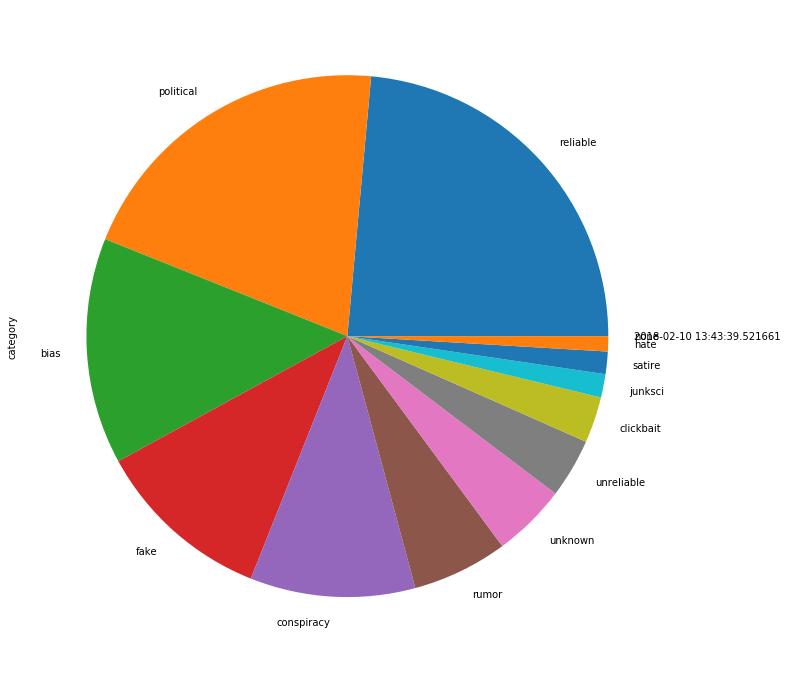

In [ ]:
categories.plot(kind='pie', figsize=(12, 12))
plt.show();

We have some oddly named categories and null values. With the next few steps we will take care of it and more...

## Set dask scheduler globally

In [ ]:
# Send data to separate processes for processing. This option 
# is good when operating on pure Python objects like strings.
dask.config.set(scheduler='processes')

## Remove html links, digits, stop words and lemmatize text

In [ ]:
ddf['news_content'] = ddf['news_content'].map(func.remove_html, meta=pd.Series(dtype='O'))

In [ ]:
ddf['news_content'] = ddf['news_content'].map(func.remove_digits, meta=pd.Series(dtype='O'))

In [ ]:
ddf['news_content'] = ddf['news_content'].map(func.stopwords_lemmatizing, meta=pd.Series(dtype='O'))

**TODO**: figure out a way to improve speed.

## Create balanced dataset

Let us recall how the categories are distributed and create a dataset which has only two categories: `reliable` and `unreliable`. We will combine a few categories into one for category `unreliable`.

In [ ]:
num_unreliable = categories['conspiracy'] + categories['fake'] + categories['unreliable']
print('Total number of unreliable content: {}'.format(num_unreliable))

Total number of unreliable content: 2024765


Let us combine the above categories into one and then make both (`reliable` and `unreliable`) categories the same size. And while we are at it, drop the rest.

In [ ]:
ddf['category'] = ddf['category'].map({'reliable': 'reliable', 'unreliable': 'unreliable', 
                                       'conspiracy': 'unreliable', 'fake': 'unreliable'})

In [ ]:
ddf = ddf.dropna()

In [ ]:
with ProgressBar():
    ddf.to_parquet('/storage/data/cleaned')

[########################################] | 100% Completed |  2hr 20min 48.3s


## Just making sure

In [ ]:
ddf = dd.read_parquet('/storage/data/cleaned')

In [ ]:
ddf.isnull().sum().sum().compute(num_workers=4)

0

In [ ]:
categories = ddf.category.value_counts().compute(num_workers=4)
categories

unreliable    2024765
reliable      1913222
Name: category, dtype: int64

Our dataset looks much better now, no Nan values and only two categories.

# train_test_split datset

## HACK

For some reason we are missing two files somehwere in the list. To fix it and be able to work better with it we will convert them to csv. Also, the parquet files are named `part.0.parquet` and get converted to csv with `000.part` naming and therefore are sorted.

In [ ]:
with ProgressBar():
    ddf = dd.read_parquet('/storage/data/cleaned')
    ddf = ddf.to_csv('/storage/data/cleaned_csv', index=False)

[########################################] | 100% Completed |  1min 27.2s


## Concatenate files

To concatenate the cleaned csv files into one makes only sense if we have a lot of memory, like we have at paperspace. Otherwise we will run into errors like the following: `OSError: [Errno 12] Cannot allocate memory`

In [ ]:
allFiles = glob.glob("/storage/data/cleaned_csv/*")
out_file = Path('/storage/data/cleaned_news_data.csv')

with tqdm() as progress:
    for i, file in enumerate(sorted(allFiles)):
        df = pd.read_csv(file)

        if i == 0:
            df.to_csv(out_file, index=False)
        else:
            df.to_csv(out_file, index=False, mode='a', header=False)
            
        progress.update()

231it [06:22,  4.12s/it]


In [ ]:
size = os.path.getsize(out_file)
print('The cleaned dataset is {0:.2f} GB'.format(convert_byte_to(size, 'g')))

The cleaned dataset is 6.54 GB


Let us split the dataset into a training and a test dataset a different way without filling up our memory. A nearly 7GB csv file will be more than 20GB in memory with pandas.

In [ ]:
train_file = Path('/storage/data/train_data.csv')
test_file = Path('/storage/data/test_data.csv')

In [ ]:
def split_dataset(i, df):
    train, test = train_test_split(df, test_size=0.2)

    if i == 0:
        train.to_csv(train_file, index=False)
        test.to_csv(test_file, index=False)
    else:
        train.to_csv(train_file, index=False, mode='a', header=False)
        test.to_csv(test_file, index=False, mode='a', header=False)

In [ ]:
n_files = len([name for name in os.listdir('/storage/data/cleaned_csv/')])

template = '/storage/data/cleaned_csv/{:03d}.part'
filenames = [template.format(k) for k in range(0, n_files)]
dataframes = (pd.read_csv(fname) for fname in filenames)

In [ ]:
with tqdm() as progress:
    for i, df in enumerate(dataframes):
        split_dataset(i, df)

        progress.update()

231it [06:10,  3.25s/it]


---

# Keras

In [7]:
train_data = Path('/storage/data/train_bool_data.csv')
valid_data = Path('/storage/data/valid_bool_data.csv')

In [8]:
train_size = 0
with open(train_data, 'r') as f:
    for line in tqdm(f):
        train_size += 1

3150390it [00:16, 189338.48it/s]


In [9]:
valid_size = 0
with open(valid_data, 'r') as f:
    for line in tqdm(f):
        valid_size += 1

787599it [00:04, 180622.41it/s]


## Cache GloVe 100d

We are going to use the Global Vectors for Word Representation which can be found [here](https://nlp.stanford.edu/projects/glove/).

In [10]:
f = open('/storage/data/glove.6B.100d.txt', 'r')

glove = {}
for line in tqdm(f):
    values = line.split()
    
    word = values[0]
    glove[word] = np.asarray(values[1:], dtype='float32')
    
f.close()

400000it [00:11, 35268.80it/s]


## Create Generator

Because of the size of our data we need to create our own generator in order to read the data line by line.

In [11]:
def _generator_process_line(line):
    # initialize content
    embedding = np.zeros((max_words, 100))
    
    # iterate over each word in line
    for i, word in enumerate(line[0].split()[:max_words]):
        # get vector if word is in glove
        if word in glove:
            embedding[i] = glove[word]
            
    return embedding, line[1]

def Generator(data, batch_size):
    while True:
        with open(data, 'r') as f:
            # skip header
            for _ in range(1):
                next(f)
            
            # initialize content and category using numpy
            batch_i = 0
            batch_embedding = np.zeros((batch_size, max_words, 100))
            batch_category = np.zeros((batch_size, 1))
            
            # read over each line
            reader = csv.reader(f)
            for line in reader:
                # process each line
                embedding, category = _generator_process_line(line)                
                
                # set batch values, if iterator plus 1 equals batch_size re-initialize
                if (batch_i + 1) == batch_size:
                    yield batch_embedding, batch_category
                    
                    batch_embedding = np.zeros((batch_size, max_words, 100))
                    batch_category = np.zeros((batch_size, 1))
                    batch_i = 0
                else:
                    batch_embedding[batch_i] = embedding
                    batch_category[batch_i, 0] = category
                    batch_i += 1

## Define some variables

The more words we want to have in our model the slower the calaculation, but it might be worth running 2, 3 epochs to see what the outcome is.

In [12]:
max_words = 250
input_shape = max_words, 100

filters = 250
kernel_size = 3
hidden_dims = 250

batch_size = 128
epochs = 20

## Define a keras model

In [13]:
def cnn_model(input_shape, filters=250, kernel_size=3, hidden_dims=250):
    model = Sequential([
        Conv1D(filters, kernel_size, input_shape=(input_shape[0], input_shape[1]), 
               padding='valid', activation='relu', strides=1),
        GlobalMaxPooling1D(),
        Dense(hidden_dims),
        Dropout(0.2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # We only looking for reliable vs unreliable targets
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [14]:
model = cnn_model(input_shape, filters, kernel_size, hidden_dims)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 248, 250)          75250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)      

Let's use tensorflow on one GPU. Next step would be calculate the model on [multiple GPU's](https://www.tensorflow.org/guide/using_gpu#using_multiple_gpus).

In [15]:
with tf.device('/gpu:0'):
    history = model.fit_generator(Generator(train_data, batch_size), 
                                  steps_per_epoch=train_size//batch_size,
                                  validation_data=Generator(valid_data, batch_size), 
                                  validation_steps=valid_size//batch_size,
                                  epochs=epochs, verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
 3491/24612 [===>..........................] - ETA: 35:39 - loss: 0.0682 - acc: 0.9739

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8921/24612 [=========>....................] - ETA: 26:43 - loss: 0.0664 - acc: 0.9744

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15461/24612 [=================>............] - ETA: 16:22 - loss: 0.0648 - acc: 0.9750

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24612/24612 [==============================] - 2980s 121ms/step - loss: 0.0633 - acc: 0.9757 - val_loss: 0.0627 - val_acc: 0.9759
Epoch 3/20
 1663/24612 [=>............................] - ETA: 39:05 - loss: 0.0591 - acc: 0.9777

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24612/24612 [==============================] - 2833s 115ms/step - loss: 0.0556 - acc: 0.9788 - val_loss: 0.0560 - val_acc: 0.9784
Epoch 4/20
24612/24612 [==============================] - 2895s 118ms/step - loss: 0.0509 - acc: 0.9807 - val_loss: 0.0575 - val_acc: 0.9778
Epoch 5/20
24612/24612 [==============================] - 2881s 117ms/step - loss: 0.0474 - acc: 0.9820 - val_loss: 0.0626 - val_acc: 0.9762
Epoch 6/20
24612/24612 [==============================] - 2860s 116ms/step - loss: 0.0446 - acc: 0.9831 - val_loss: 0.0589 - val_acc: 0.9784
Epoch 7/20
24612/24612 [==============================] - 3410s 139ms/step - loss: 0.0426 - acc: 0.9839 - val_loss: 0.0589 - val_acc: 0.9784
Epoch 8/20
24612/24612 [==============================] - 3249s 132ms/step - loss: 0.0409 - acc: 0.9845 - val_loss: 0.0569 - val_acc: 0.9790
Epoch 9/20
24612/24612 [==============================] - 3098s 126ms/step - loss: 0.0393 - acc: 0.9851 - val_loss: 0.0570 - val_acc: 0.9793
Epoch 10/20
24612/24612 

In [18]:
# Evaluate the model on a data generator.
#
scores = model.evaluate_generator(Generator(valid_data, batch_size), steps=valid_size//batch_size, verbose=0)
print("Accuracy Score ({}): {:.2f}%".format(model.metrics_names[1], scores[1]*100))

Accuracy Score (acc): 97.83%


In [19]:
# Save a Keras model into a single HDF5 file which will contain:
# + the architecture of the model, allowing to re-create the model
# + the weights of the model
# + the training configuration (loss, optimizer)
# + the state of the optimizer, allowing to resume training exactly where you left off.
#
model.save('/storage/data/cnn_model.h5')

## Visualize accurarcy and loss

In [22]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='training acc')
    plt.plot(epochs, val_acc, 'r', label='validation acc')
    plt.title('training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='training loss')
    plt.plot(epochs, val_loss, 'r', label='validation loss')
    plt.title('training and validation loss')
    plt.legend()
    
    plt.show();

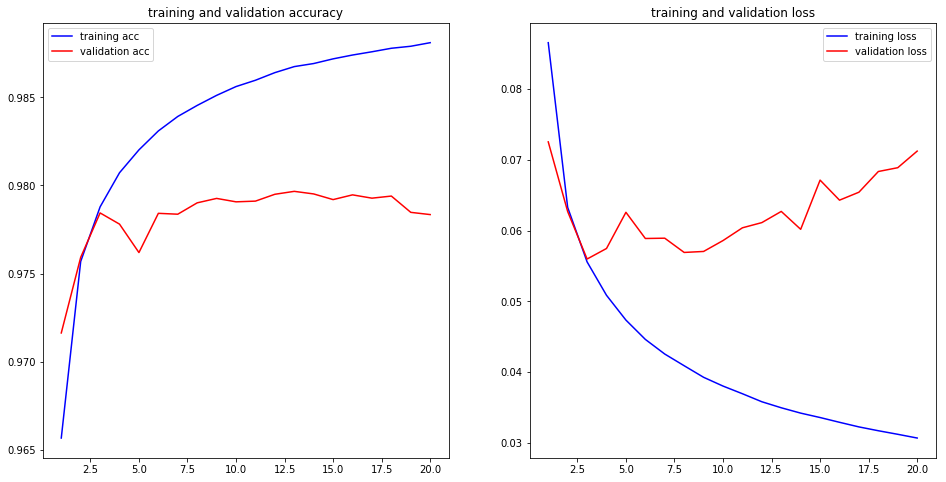

In [23]:
plot_history(history)

To improve the model we saved out we should save it after each epoch to keep the best version.

## Next Step:

+ add prediction for a given text
+ add "content" and "context" only kera models